In [1]:
import os
from torch.utils.data import DataLoader,Dataset
import torchvision
import torchvision.transforms as transforms
from PIL import Image
import cv2
import numpy as np
import pandas as pd
from torchvision import models
from pathlib import Path
# from fastai.vision import Path
import torch
import torch.nn as nn
from torch.autograd import Variable
import matplotlib.pyplot as plt
import time
import os
import copy


### 목적변수 처리를 위한 OneHot Vector 생성준비¶

In [2]:
NUMBER = ['0', '1', '2', '3', '4', '5', '6', '7', '8', '9']
# ALPHABET = ['A', 'B', 'C', 'D', 'E', 'F', 'G', 'H', 'I', 'J', 'K', 'L', 'M', 'N', 'O', 'P', 'Q', 'R', 'S', 'T', 'U', 'V', 'W', 'X', 'Y', 'Z']
ALPHABET = ['a', 'b', 'c', 'd', 'e', 'f', 'g', 'h', 'i', 'j', 'k', 'l', 'm', 'n', 'o', 'p', 'q', 'r', 's', 't', 'u', 'v', 'w', 'x', 'y', 'z']
ALL_CHAR_SET = NUMBER + ALPHABET
ALL_CHAR_SET_LEN = len(ALL_CHAR_SET)
MAX_CAPTCHA = 5

In [3]:
print("ALL_CHAR_SET : {}".format(ALL_CHAR_SET))
print("ALL_CHAR_SET_LEN : {}".format(ALL_CHAR_SET_LEN))

ALL_CHAR_SET : ['0', '1', '2', '3', '4', '5', '6', '7', '8', '9', 'a', 'b', 'c', 'd', 'e', 'f', 'g', 'h', 'i', 'j', 'k', 'l', 'm', 'n', 'o', 'p', 'q', 'r', 's', 't', 'u', 'v', 'w', 'x', 'y', 'z']
ALL_CHAR_SET_LEN : 36


#### One - Hot Labels
이제 우리의 정답 y를 one hot vector로 바꿉시다.
one hot vector이란 모든 벡터의 원소들 중 하나만 1인 벡터를 의미합니다.

예를 들어, one hot vector로 0를 표현하면 [1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0] 이 될 수 있겠죠.(36개)

In [4]:
def encode(a):
    onehot = [0]*ALL_CHAR_SET_LEN
    idx = ALL_CHAR_SET.index(a)
    onehot[idx] += 1
    return onehot

In [5]:
encode('0')
len(encode('0'))
print("encode('0') : {}".format(encode('0')))
print("len(encode('0')) : {}".format(len(encode('0'))))

encode('0') : [1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
len(encode('0')) : 36


#### 일부 이미지 시각화하기
데이터 증가를 이해하기 위해 일부 학습용 이미지를 시각화해보겠습니다.

Number of images found:  1040
Shape of image:  (50, 200, 3)
Shape of image:  (50, 200, 3)
Shape of image:  (50, 200, 3)
Shape of image:  (50, 200, 3)


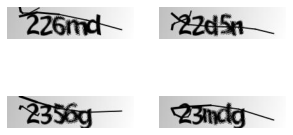

In [6]:
# Path to the data directory
# data_dir = Path("../input/captcha-version-2-images/samples/")
data_dir = Path('captcha-version-2-images/samples/samples')
# data_dir = Path('data/giro')



# Get list of all the images
images = list(data_dir.glob("*.png"))
print("Number of images found: ", len(images))


# Let's take a look at some samples first. 
# Always look at your data!
sample_images = images[:4]

_,ax = plt.subplots(2,2, figsize=(5,3))
for i in range(4):
    img = cv2.imread(str(sample_images[i]))
    print("Shape of image: ", img.shape)
    ax[i//2, i%2].imshow(img)
    ax[i//2, i%2].axis('off')
plt.show()

### 종속변수 처리를 위한 데이터셋 불러오기¶
torch.utils.data.DataLoader를 이용해서 입력 데이터를 불러온다. DataLoader의 입력 파라미터로는 (경로, Transform 옵션)을 포함하는 ImageFolder함수와 배치사이즈, 그리고 셔플 옵션이 있다. DataLoader의 파라미터 중 하나인 num_workers는 스레드 갯수를 설정하는 것인데, 필자의 경우 4로 했을 때 오류가 발생해서 스레드 갯수를 0으로 설정했다.

​

처음 볼 땐 난해한 문법들이 많을 텐데, 파이썬 딕셔너리 자료형에 대한 개념을 안다면 무난하게 이해할 수 있다. 잘 이해가 안된다면 딕셔너리 자료형에 대한 내용을 한번 읽고 오도록 하자.

In [7]:
class Mydataset(Dataset):
    def __init__(self, path, is_train=True, transform=None):
        self.path = path
        if is_train: self.img = os.listdir(self.path)[:1000]
        else: self.img = os.listdir(self.path)[1001:]
        try: self.img.remove('3bnfnd.png')
        except: pass
        self.transform = transform
        
    def __getitem__(self, idx):
        img_path = self.img[idx]
        img = Image.open(self.path/img_path)
        img = img.convert('L')
        label = Path(self.path/img_path).name[:-4]
        label_oh = []
        for i in label:
            label_oh += encode(i)
        if self.transform is not None:
            img = self.transform(img)
        return img, np.array(label_oh), label
    
    def __len__(self):
        return len(self.img)

In [8]:
transform = transforms.Compose([
    transforms.Resize([224, 224]),
    transforms.ToTensor(),
])

In [9]:
train_ds = Mydataset(data_dir, transform=transform)
test_ds = Mydataset(data_dir, False, transform)
train_dl = DataLoader(train_ds, batch_size=64, num_workers=0)
test_dl = DataLoader(test_ds, batch_size=1, num_workers=0)

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

print("Number of training samples: ", len(train_ds))
print("Number of test samples: ", len(test_ds))



cuda:0
Number of training samples:  1000
Number of test samples:  69


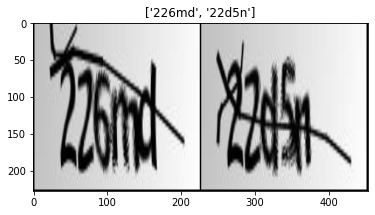

In [10]:
def imshow(inp, title=None):
    """Imshow for Tensor."""
    inp = inp.numpy().transpose((1, 2, 0))
#     mean = np.array([0.485, 0.456, 0.406])
#     std = np.array([0.229, 0.224, 0.225])
#     inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    plt.imshow(inp)
    if title is not None:
        plt.title(title)
    plt.pause(0.001)  # 갱신이 될 때까지 잠시 기다립니다.

# 학습 데이터의 배치를 얻습니다.
# 한개의 배치(batch)만큼 이미지를 불러온다. 배치 사이즈를 64로 했으니 사진 64장이 로드된다.
dataiter = iter(train_dl)
inputs, label_oh, classes = dataiter.next()


# 배치로부터 격자 형태의 이미지를 만듭니다.
# 로드된 데이터에 make_grid 함수를 통해 그리드를 추가한다.
# 로드된 데이터 중에서 4개만 추출한다.
out = torchvision.utils.make_grid(inputs[:2])

# 이미지를 출력한다.
imshow(out, title=[x for x in classes[:2]])


In [11]:
print("inputs")
print(inputs[0])
print(inputs.size())

inputs
tensor([[[0.7529, 0.7529, 0.7529,  ..., 0.9843, 0.9843, 0.9843],
         [0.7529, 0.7529, 0.7529,  ..., 0.9843, 0.9843, 0.9843],
         [0.7529, 0.7529, 0.7529,  ..., 0.9843, 0.9843, 0.9843],
         ...,
         [0.7647, 0.7647, 0.7647,  ..., 0.9961, 0.9961, 0.9961],
         [0.7647, 0.7647, 0.7647,  ..., 0.9961, 0.9961, 0.9961],
         [0.7647, 0.7647, 0.7647,  ..., 0.9961, 0.9961, 0.9961]]])
torch.Size([64, 1, 224, 224])


In [12]:
print("label_oh")
print(label_oh[0])
print(label_oh.size())

label_oh
tensor([0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], dtype=torch.int32)
torch.Size([64, 180])


In [13]:
print("classes")
print(classes[0])
print(len(classes))

classes
226md
64


### ResNet18 모델기반 신경망 정의하기
이제 신경망을 정의해보겠습니다

Transfer Learning의 핵심! Pretrained model을 가져온다. 본 예제에서는 ResNet18 모델을 이용하였다. model_ft.fc.in_features는 ResNet18모델의 마지막 단에서, 출력 노드의 갯수를 구해주는 함수이다. Pretrained-model의 끝단에 Fully connected layer를 추가로 삽입하고 노드를 연결시켜 주는 것이 우리가 사용할 모델이 된다. 가장 핵심이지만 가장 심플하다고 할 수 있다.

​

*이 때, Fully connected layer 즉 Linear layer의 출력 노드 갯수는 Class의 갯수와 같아야한다.

본 예제는 캡차에 적용된 영숫자와 인식필요 캡차영숫자의 곱으로 이루어진 ALL_CHAR_SET_LENMAX_CAPTCHA이므로, 출력 노드 갯수는 ALL_CHAR_SET_LENMAX_CAPTCHA가 된다.

In [14]:
def get_model():
    """
    """
    model = models.resnet18(pretrained=False)
    model.conv1 = nn.Conv2d(1, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    model.fc = nn.Linear(in_features=512, out_features=ALL_CHAR_SET_LEN*MAX_CAPTCHA, bias=True)
    return model

# 모델 정의 
model = get_model().to(device)

### 손실함수정의

In [15]:
loss_func = nn.MultiLabelSoftMarginLoss()
optm = torch.optim.Adam(model.parameters(), lr=0.001)

### 모델 학습하기

In [16]:
since = time.time()
num_epochs = 50
for epoch in range(num_epochs):
    print(' ' * 50)
    print('Epoch {}/{}'.format(epoch+1, num_epochs))
    print('-' * 10)
    for step, i in enumerate(train_dl):
        img, label_oh, label = i
        img = Variable(img).to(device)
        label_oh = Variable(label_oh.float()).to(device)
        pred = model(img)
        loss = loss_func(pred, label_oh)
        optm.zero_grad()
        loss.backward()
        optm.step()
        print('step:', step+1, 'loss:', loss.item())

time_elapsed = time.time() - since
print('=' * 50)
print('Training complete in {:.0f}m {:.0f}s'.format(time_elapsed // 60, time_elapsed % 60))

                                                  
Epoch 1/50
----------
step: 1 loss: 0.7118784189224243
step: 2 loss: 0.510631799697876
step: 3 loss: 0.34741073846817017
step: 4 loss: 0.24329723417758942
step: 5 loss: 0.1804269254207611
step: 6 loss: 0.14372611045837402
step: 7 loss: 0.13471588492393494
step: 8 loss: 0.1288556158542633
step: 9 loss: 0.1280224323272705
step: 10 loss: 0.1302318125963211
step: 11 loss: 0.13083693385124207
step: 12 loss: 0.13260021805763245
step: 13 loss: 0.13986599445343018
step: 14 loss: 0.13234780728816986
step: 15 loss: 0.13024234771728516
step: 16 loss: 0.13397014141082764
                                                  
Epoch 2/50
----------
step: 1 loss: 0.1256852149963379
step: 2 loss: 0.12378571927547455
step: 3 loss: 0.119438037276268
step: 4 loss: 0.11351880431175232
step: 5 loss: 0.1126229539513588
step: 6 loss: 0.11329733580350876
step: 7 loss: 0.11263839900493622
step: 8 loss: 0.11048413068056107
step: 9 loss: 0.11163456737995148
step: 10

step: 3 loss: 0.06863045692443848
step: 4 loss: 0.06643742322921753
step: 5 loss: 0.06993681192398071
step: 6 loss: 0.06685429811477661
step: 7 loss: 0.06751140207052231
step: 8 loss: 0.062233638018369675
step: 9 loss: 0.06136023625731468
step: 10 loss: 0.0656111091375351
step: 11 loss: 0.06493924558162689
step: 12 loss: 0.07416558265686035
step: 13 loss: 0.06539161503314972
step: 14 loss: 0.06038100644946098
step: 15 loss: 0.0695001631975174
step: 16 loss: 0.06022436544299126
                                                  
Epoch 15/50
----------
step: 1 loss: 0.06432241201400757
step: 2 loss: 0.06185654550790787
step: 3 loss: 0.06057048216462135
step: 4 loss: 0.059253886342048645
step: 5 loss: 0.06386055052280426
step: 6 loss: 0.062077127397060394
step: 7 loss: 0.06201013922691345
step: 8 loss: 0.055707596242427826
step: 9 loss: 0.05505714565515518
step: 10 loss: 0.059806883335113525
step: 11 loss: 0.05879949778318405
step: 12 loss: 0.06696021556854248
step: 13 loss: 0.059679858386

step: 3 loss: 0.018091782927513123
step: 4 loss: 0.0161580890417099
step: 5 loss: 0.016317594796419144
step: 6 loss: 0.02265927568078041
step: 7 loss: 0.019271837547421455
step: 8 loss: 0.014245395548641682
step: 9 loss: 0.013544821180403233
step: 10 loss: 0.013290364295244217
step: 11 loss: 0.019657796248793602
step: 12 loss: 0.02395913377404213
step: 13 loss: 0.023289479315280914
step: 14 loss: 0.012460293248295784
step: 15 loss: 0.014449084177613258
step: 16 loss: 0.02049761824309826
                                                  
Epoch 28/50
----------
step: 1 loss: 0.019015269353985786
step: 2 loss: 0.0148224588483572
step: 3 loss: 0.015334825962781906
step: 4 loss: 0.016127809882164
step: 5 loss: 0.014221815392374992
step: 6 loss: 0.02109738439321518
step: 7 loss: 0.015657059848308563
step: 8 loss: 0.011972134932875633
step: 9 loss: 0.012162970378994942
step: 10 loss: 0.012495359405875206
step: 11 loss: 0.016104549169540405
step: 12 loss: 0.022260814905166626
step: 13 loss: 0.

step: 1 loss: 0.0040612248703837395
step: 2 loss: 0.003578300355002284
step: 3 loss: 0.005573755130171776
step: 4 loss: 0.004821154288947582
step: 5 loss: 0.003412495367228985
step: 6 loss: 0.004683465696871281
step: 7 loss: 0.003932467661798
step: 8 loss: 0.0030792071484029293
step: 9 loss: 0.0028403564356267452
step: 10 loss: 0.0031405072659254074
step: 11 loss: 0.004100746475160122
step: 12 loss: 0.0058716535568237305
step: 13 loss: 0.006894923746585846
step: 14 loss: 0.0027669055853039026
step: 15 loss: 0.0034215832129120827
step: 16 loss: 0.0044653513468801975
                                                  
Epoch 41/50
----------
step: 1 loss: 0.003782871877774596
step: 2 loss: 0.005555348936468363
step: 3 loss: 0.0041890740394592285
step: 4 loss: 0.0031532160937786102
step: 5 loss: 0.0031164116226136684
step: 6 loss: 0.004598861560225487
step: 7 loss: 0.003585524158552289
step: 8 loss: 0.002699322532862425
step: 9 loss: 0.0027204419020563364
step: 10 loss: 0.003287508385255933

### 모델 예측값 시각화하기
일부 이미지에 대한 예측값을 보여주는 일반화된 함수입니다.

In [ ]:
def visualize_model(input_model, num_images=6):
    was_training = input_model.training
    input_model.eval()
    images_so_far = 0
    fig = plt.figure()
    test_correct = 0
    test_total = len(test_dl.dataset)
    print("test_total=",test_total)

    with torch.no_grad():
        for i, (inputs, label_oh, label) in enumerate(test_dl):
            
            view_image = torchvision.utils.make_grid(inputs)
            inputs = Variable(inputs).to(device)
#             labels = labels.to(device)

            outputs = input_model(inputs)
    
            c0 = ALL_CHAR_SET[np.argmax(outputs.squeeze().cpu().tolist()[0:ALL_CHAR_SET_LEN])]
            c1 = ALL_CHAR_SET[np.argmax(outputs.squeeze().cpu().tolist()[ALL_CHAR_SET_LEN:ALL_CHAR_SET_LEN*2])]
            c2 = ALL_CHAR_SET[np.argmax(outputs.squeeze().cpu().tolist()[ALL_CHAR_SET_LEN*2:ALL_CHAR_SET_LEN*3])]
            c3 = ALL_CHAR_SET[np.argmax(outputs.squeeze().cpu().tolist()[ALL_CHAR_SET_LEN*3:ALL_CHAR_SET_LEN*4])]
            c4 = ALL_CHAR_SET[np.argmax(outputs.squeeze().cpu().tolist()[ALL_CHAR_SET_LEN*4:ALL_CHAR_SET_LEN*5])]
            preds_label = '%s%s%s%s%s' % (c0, c1, c2, c3, c4)
#             c5 = ALL_CHAR_SET[np.argmax(outputs.squeeze().cpu().tolist()[ALL_CHAR_SET_LEN*5:ALL_CHAR_SET_LEN*6])]
#             preds_label = '%s%s%s%s%s%s' % (c0, c1, c2, c3, c4, c5)

            correct = ""
            if label[0] == preds_label:
                test_correct += 1
                correct = "True"
            else:
                correct = "False"
                
            
            print("Lable : {} Prediction Lable : {} 맟춤여부 : {}".format(label[0], preds_label, correct))

            # 맞추지 못한 이미지를 출력한다.
            if (correct == "False") and (num_images > i):
                imshow(view_image, title='{} predicted: {}  {}'.format(i+1, preds_label, correct))

        input_model.train(mode=was_training)
        
    print(f'Test Accuracy: {(test_correct/test_total):.5f} ' +  f'({test_correct}/{test_total})')

### 모델 학습결과 테스트 데이터로 테스트

In [ ]:
# visualize_model(model)

In [17]:
model.eval();

In [18]:
test_correct = 0
test_total = len(test_dl.dataset)
print("test_total=",test_total)

for step, (img, label_oh, label) in enumerate(test_dl):
    img = Variable(img).cuda()
    pred = model(img)

    c0 = ALL_CHAR_SET[np.argmax(pred.squeeze().cpu().tolist()[0:ALL_CHAR_SET_LEN])]
    c1 = ALL_CHAR_SET[np.argmax(pred.squeeze().cpu().tolist()[ALL_CHAR_SET_LEN:ALL_CHAR_SET_LEN*2])]
    c2 = ALL_CHAR_SET[np.argmax(pred.squeeze().cpu().tolist()[ALL_CHAR_SET_LEN*2:ALL_CHAR_SET_LEN*3])]
    c3 = ALL_CHAR_SET[np.argmax(pred.squeeze().cpu().tolist()[ALL_CHAR_SET_LEN*3:ALL_CHAR_SET_LEN*4])]
    c4 = ALL_CHAR_SET[np.argmax(pred.squeeze().cpu().tolist()[ALL_CHAR_SET_LEN*4:ALL_CHAR_SET_LEN*5])]
    c = '%s%s%s%s%s' % (c0, c1, c2, c3, c4)
    
    correct = ""
    if label[0] == preds_label:
        test_correct += 1
        correct = "True"
    else:
        correct = "False"
                
    print("Lable : {} Prediction Lable : {} 맟춤여부 : {}".format(label[0], preds_label, correct))

    # 맞추지 못한 이미지를 출력한다.
    if (correct == "False") and (num_images > i):
        imshow(view_image, title='{} predicted: {}  {}'.format(i+1, preds_label, correct))

#     print('label:', label[0], 'pred:', c)
print(f'Test Accuracy: {(test_correct/test_total):.5f} ' +  f'({test_correct}/{test_total})')

label: xfgxb pred: x7dxb
label: xfn6n pred: x4n6n
label: xgcxy pred: xgcxy
label: xmcym pred: x3cym
label: xnd3y pred: x3d2y
label: xnfx5 pred: x2fx5
label: xngxc pred: xngxc
label: xnn4d pred: xnn4d
label: xnnc3 pred: x3nc3
label: xp24p pred: xp24p
label: xw465 pred: xw3w5
label: xwx7d pred: x367d
label: xxbm5 pred: x3bm6
label: xxney pred: xxney
label: xxw44 pred: xxnw4
label: xymfn pred: xyffn
label: xyncc pred: xyncc
label: xyyyw pred: xyfxw
label: y2436 pred: 77436
label: y2xg4 pred: x2xg4
label: y2ye8 pred: 72ye8
label: y32yy pred: f32yy
label: y33nm pred: f33nm
label: y3c58 pred: 73c58
label: y48c3 pred: 74823
label: y4ec2 pred: x4cc2
label: y4g3b pred: 7432b
label: y4n6m pred: x4n6m
label: y53c2 pred: f53c2
label: y5dpp pred: 75dpp
label: y5g87 pred: 75g87
label: y5n6d pred: 75n6d
label: y5w28 pred: f5w28
label: y7d75 pred: 77d75
label: y7mnm pred: 77mnm
label: y7x8p pred: 77xep
label: y866y pred: f666y
label: ybfx6 pred: 7bfx6
label: ycmcw pred: xcwcw
label: ycnfc pred: 7cnfc


### 학습한 모델 저장
지금까지 인공신경망을 구현하고 학습시켜 보았습니다. 이제 학습된 모델을 .pt 파일로 저장해 보겠습니다.

In [ ]:
torch.save(model.state_dict(), 'model/GIRO_Breaking_Model.pt')
print("save last model")


save() 를 실행하고 나면 학습된 신경망의 가중치를 내포하는 GIRO_Breaking_Model.pt 라는 파일이 생성됩니다.

아래 코드처럼 GIRO_Breaking_Model.pt.pt를 다시 load하는 것도 가능합니다.

In [ ]:
new_model = get_model().to(device)
new_model = new_model.eval()
new_model.load_state_dict(torch.load('model/GIRO_Breaking_Model.pt'))
print("load saved_model.")

#### 업로드한 모델로 다시한번 테스트

In [ ]:
visualize_model(new_model)

### 학습모델이용 캡차 이미지 숫자인식
이미지 파일을 주고 이미지 파일 내에 있는 글자를 출력한다

In [ ]:
# 코드 3-1

import matplotlib.pyplot as plt
from PIL import Image

img = Image.open('data/giro_test/SRVWR3.png')
# img = Image.open('captcha-version-2-images/captcha01.png')
# PIL 객체 확인
print("type: {}".format(type(img)))
# 이미지 흑백으로 변경, 크기변화: 150x150x3 > 150x150x1
img = img.convert("L") 
# 이미지 크기 조회
print("size of image: {}".format(img.size))
img

In [ ]:
# Process our image
def process_image(image_path):
    # Load Image
    img = Image.open(image_path)
    # Load Image
    img = img.convert('L')
    # Resize Image [1, 224, 224]
    img = transform(img)
    
    # Turn image into numpy array
    img = np.array(img)
    
    
    # Add a fourth dimension to the beginning to indicate batch size
    img = img[np.newaxis,:]
    
#     # Turn into a torch tensor
    image = torch.from_numpy(img)
    image = image.float()
    return image

In [ ]:
input = process_image('data/giro_test/SRVWR3.png')
print(input.size())
plt.imshow(input.squeeze().detach().numpy(), cmap="gray")
plt.axis("off")
plt.show()
# image = input[:,0][:,None].type(torch.FloatTensor).to(device) # select only 1 channel (all channel equal)
# print(image.size())

In [ ]:
def get_predict(model, path):

    model.eval()
    predict_label = ""
    input = process_image(path)
    print(input.size())
    
    img = Variable(input).to(device)

    output = model(img)

    c0 = ALL_CHAR_SET[np.argmax(output.squeeze().cpu().tolist()[0:ALL_CHAR_SET_LEN])]
    c1 = ALL_CHAR_SET[np.argmax(output.squeeze().cpu().tolist()[ALL_CHAR_SET_LEN:ALL_CHAR_SET_LEN*2])]
    c2 = ALL_CHAR_SET[np.argmax(output.squeeze().cpu().tolist()[ALL_CHAR_SET_LEN*2:ALL_CHAR_SET_LEN*3])]
    c3 = ALL_CHAR_SET[np.argmax(output.squeeze().cpu().tolist()[ALL_CHAR_SET_LEN*3:ALL_CHAR_SET_LEN*4])]
    c4 = ALL_CHAR_SET[np.argmax(output.squeeze().cpu().tolist()[ALL_CHAR_SET_LEN*4:ALL_CHAR_SET_LEN*5])]
    predict_label = '%s%s%s%s%s' % (c0, c1, c2, c3, c4)
#     c5 = ALL_CHAR_SET[np.argmax(output.squeeze().cpu().tolist()[ALL_CHAR_SET_LEN*5:ALL_CHAR_SET_LEN*6])]
#     predict_label = '%s%s%s%s%s%s' % (c0, c1, c2, c3, c4, c5)

   
    return predict_label


In [ ]:
get_predict(new_model, 'data/giro_test/SRVWR3.png')